In [5]:
# Homemade imports
from qiskit_algorithms import VarQITE, TimeEvolutionProblem
from qiskit_algorithms.gradients import LinCombEstimatorGradient, LinCombQGT
import qiskit_algorithms.utils as utils
import qiskit_algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle as mc_lachlan

In [6]:
mc_lachlan.idiot_function()

Idiot function


In [7]:
# Other imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit.primitives import Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

In [8]:
# Hamiltonian reading
data = np.loadtxt('qubit_hamil_h2.txt', dtype=str) # H2, 0.7A sto6g
paulistrings = data[:,0] 
coefficients = (data[:,1])
coefficients = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
qubit_op = SparsePauliOp.from_list(paulis)

print(f"Number of qubits: {qubit_op.num_qubits}")

Number of qubits: 2


In [19]:
# Equivalent problem to Hamiltonian
driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.7",
    unit=DistanceUnit.ANGSTROM,
    charge=0,
    spin=0,
    basis='sto6g'
)
problem = driver.run()
h = problem.hamiltonian.second_q_op()

In [16]:
# Estimator
seed = 170
estimator = Estimator(options={'seed': seed})

In [20]:
# Mapper
mapper = ParityMapper(num_particles = problem.num_particles)
qubit_op2 = mapper.map(h)

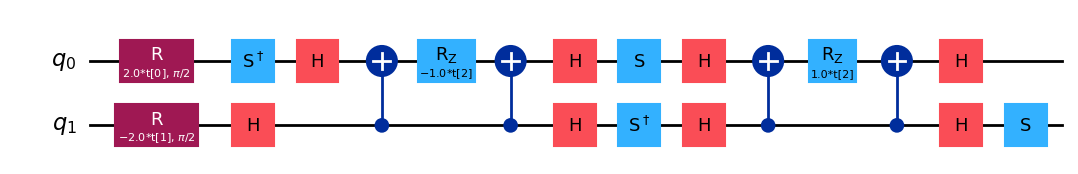

In [12]:
# Ansatz, UCCSD
ansatz = UCCSD(num_spatial_orbitals = problem.num_spatial_orbitals, num_particles = problem.num_particles, qubit_mapper=mapper)
ansatz.decompose().decompose().decompose().draw("mpl")

In [13]:
# Initial state
hf_state = HartreeFock(num_spatial_orbitals = problem.num_spatial_orbitals, num_particles = problem.num_particles, qubit_mapper=mapper)
print(hf_state)
init_param_values = [0,3*np.pi/2,-np.pi/2] # surely there should be some systematic way of doing this...

# Testing the initial state
state = Statevector.from_int(0, 2**qubit_op.num_qubits)
test_circ = ansatz.assign_parameters(init_param_values)
state = state.evolve(test_circ)
state.draw('latex')

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          


<IPython.core.display.Latex object>

In [22]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result = qite.evolve(time_evo)

anti_hermitian in make_grad_circ: False
                              ┌───┐┌───────────┐┌─────┐┌───┐┌───┐┌───────────┐»
     q_0: ────────────────────┤ Y ├┤ Ry(__gθ0) ├┤ Sdg ├┤ H ├┤ X ├┤ Rz(__gθ2) ├»
          ┌───────────┐ ┌───┐ └─┬─┘└───────────┘└─────┘└───┘└─┬─┘└───────────┘»
     q_1: ┤ Ry(__gθ1) ├─┤ H ├───┼─────────────────────────────■───────────────»
          └───┬───┬───┘┌┴───┴┐  │      ┌───┐                                  »
  qr_aux: ────┤ H ├────┤ Sdg ├──■──────┤ H ├──────────────────────────────────»
              └───┘    └─────┘         └───┘                                  »
cr_aux: 1/════════════════════════════════════════════════════════════════════»
                                                                              »
«          ┌───┐┌───┐ ┌───┐ ┌───┐┌───┐┌───────────┐┌───┐┌───┐     
«     q_0: ┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├┤ Rz(__gθ3) ├┤ X ├┤ H ├─────
«          └─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘└───────────┘└─┬─┘├───┤┌───┐
«     q_1: ──■──┤ H ├┤ Sdg ├┤ H ├──■───

In [23]:
###############
### VarQITE ###
###############
# This is the non-TC Hamiltonian.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo = TimeEvolutionProblem(qubit_op2, 
                                time=total_time, 
                                aux_operators=[qubit_op2])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result2 = qite.evolve(time_evo)

anti_hermitian in make_grad_circ: False
                              ┌───┐┌───────────┐┌─────┐┌───┐┌───┐┌───────────┐»
     q_0: ────────────────────┤ Y ├┤ Ry(__gθ0) ├┤ Sdg ├┤ H ├┤ X ├┤ Rz(__gθ2) ├»
          ┌───────────┐ ┌───┐ └─┬─┘└───────────┘└─────┘└───┘└─┬─┘└───────────┘»
     q_1: ┤ Ry(__gθ1) ├─┤ H ├───┼─────────────────────────────■───────────────»
          └───┬───┬───┘┌┴───┴┐  │      ┌───┐                                  »
  qr_aux: ────┤ H ├────┤ Sdg ├──■──────┤ H ├──────────────────────────────────»
              └───┘    └─────┘         └───┘                                  »
cr_aux: 1/════════════════════════════════════════════════════════════════════»
                                                                              »
«          ┌───┐┌───┐ ┌───┐ ┌───┐┌───┐┌───────────┐┌───┐┌───┐     
«     q_0: ┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├┤ Rz(__gθ3) ├┤ X ├┤ H ├─────
«          └─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘└───────────┘└─┬─┘├───┤┌───┐
«     q_1: ──■──┤ H ├┤ Sdg ├┤ H ├──■───

In [24]:
data = np.loadtxt("energy_trace_h2.dat")
avqite_times = data[:,0]
avqite_energies = data[:,2]


Final Qiskit electronic energy: -1.9371863629463095 Ha


(0.0, 5.099999999999998)

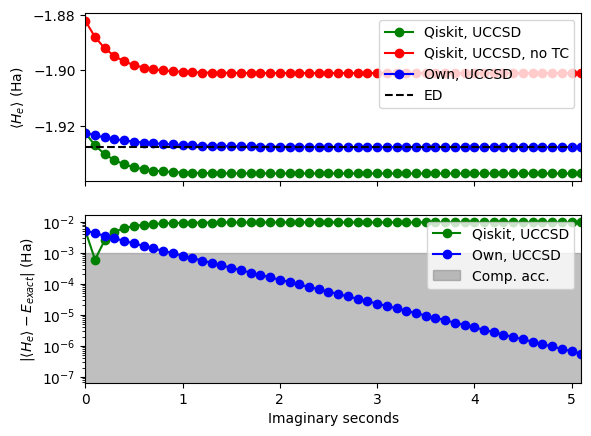

In [25]:
fig, axs = plt.subplots(2,1,sharex=True)
ax = axs[0]
ax2 = axs[1]
#DELTA_BIG = 50
DELTA_BIG = 2
sys = "h2"
e_exact = {"h2": -1.9276748321, "h4": -4.3860854160}
e_exact_notc = {"h2": -1.9009465237, "h4": None} 

# Readin from file
#with open('h_exp_val.txt', 'r') as f:
#    h_exp_val = [float(num) for line in f for num in line.strip('[] \n').split()]
#with open('times.txt', 'r') as g:
#    times = [float(num) for line in g for num in line.strip('[] \n').split()]

h_exp_val = np.array([ele[0][0].real for ele in result.observables])
times = result.times
h_ex_val2 = np.array([ele[0][0].real for ele in result2.observables])
times2 = result2.times

ax.plot(times, h_exp_val, '-go', label= "Qiskit, UCCSD") #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times2, h_ex_val2, '-ro', label= "Qiskit, UCCSD, no TC") #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(avqite_times[::DELTA_BIG], avqite_energies[::DELTA_BIG], '-bo', label= "Own, UCCSD")
ax.plot([e_exact[sys]]*(int(times[-1])+1), '--k', label= "ED")
ax.plot([e_exact[sys]]*(int(times[-1])+1), '--k')
#ax.axhline(np_result.total_energies, ls='--', 
#           c='k', alpha=0.7, label='Groundstate')
#ax.axhline(np_result.hartree_fock_energy, ls='--', 
#           c='r', alpha=0.7, label="Hartree-Fock")

#pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
ax.set_ylabel(r"$\langle H_e \rangle$ (Ha)")
ax.legend(loc="upper right")
ax.set_xlim([0, times[-1]])
print(f"Final Qiskit electronic energy: {h_exp_val[-1]} Ha")
#print(f"Compare with Qutip ED: -4.3860854160 Ha")
#print(f"Compare with TC-VarQITE for UCCSD: -4.3860791082 Ha")


ax2.plot(times, abs(h_exp_val-e_exact[sys]), "-go", label= "Qiskit, UCCSD")
ax2.plot(avqite_times[::DELTA_BIG], abs(avqite_energies-e_exact[sys])[::DELTA_BIG], "-bo", label= "Own, UCCSD")
ax2.fill_between([0,times[-1]],[1e-3,1e-3],color="grey",alpha=0.5,label="Comp. acc.")
ax2.set_xlabel("Imaginary seconds")
ax2.set_ylabel(r"$|\langle H_e \rangle - E_{exact}|$ (Ha)")
ax2.set_yscale("log")
ax2.legend(loc="upper right")
ax2.set_xlim([0, times[-1]])